# **Depedênciais Iniciais**

In [ ]:
from google.colab import files
import pandas as pd
import io

# Abre a janela para escolher o arquivo
uploaded = files.upload()

# Pega o nome do primeiro arquivo enviado
filename = list(uploaded.keys())[0]

# Lê o CSV diretamente
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Mostra as primeiras linhas para confirmar
df.head()

In [ ]:
# pip install sklearn_lvq

In [ ]:
# pip install imbalanced-learn

In [ ]:
# pip install scikit-learn-extra

# **EDA e clean**

# **Rede Neural MLP (Multilayer Perceptron), Comitê de Redes Neurais Artificiais, Comitê Heterogêneo (Stacking), XGBoost e LightGBM**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline as SkPipeline

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings('ignore')

# === 1. Carregamento e divisão ===
df = df.rename(columns={"Patient_ID": "ID"})
features = [col for col in df.columns if col not in ['ID', 'SepsisLabel']]

def aggregate_by_id(df_subset):
    numeric = df_subset[features].select_dtypes(include=np.number).columns
    categorical = df_subset[features].select_dtypes(exclude=np.number).columns

    agg_funcs = {col: ['min', 'max', 'mean'] for col in numeric}
    agg_funcs.update({col: ['first'] for col in categorical})
    agg_funcs['SepsisLabel'] = 'max'

    df_agg = df_subset.groupby('ID').agg(agg_funcs)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.rename(columns={'SepsisLabel_max': 'SepsisLabel'}, inplace=True)
    return df_agg

agg_df = aggregate_by_id(df)
X = agg_df.drop('SepsisLabel', axis=1)
y = agg_df['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_features = [col for col in X_train.columns if col not in cat_features]

# === 2. Pipeline base ===
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

# smote = SMOTE(sampling_strategy=0.3, random_state=42)
# undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
smoteenn = SMOTEENN(random_state=42)

# === 3. Modelos e Espaços de Parâmetros ===
modelos_parametros = {
    'MLP': {
        'modelo': MLPClassifier(max_iter=300, random_state=42),
        'param_grid': {
            'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'clf__activation': ['relu', 'tanh'],
            'clf__alpha': [1e-5, 1e-4, 1e-3]
        }
    },
    'Comite_MLP': {
        'modelo': BaggingClassifier(
            estimator=MLPClassifier(max_iter=300, random_state=42),
            n_jobs=-1, random_state=42
        ),
        'param_grid': {
            'clf__n_estimators': [5, 10, 20],
            'clf__estimator__hidden_layer_sizes': [(50,), (100,)],
            'clf__estimator__alpha': [1e-4, 1e-3]
        }
    },
    'XGBoost': {
        'modelo': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'param_grid': {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'LightGBM': {
        'modelo': LGBMClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'Stacking': {
        'modelo': StackingClassifier(
            estimators=[
                ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
                ('lgbm', LGBMClassifier(random_state=42))
            ],
            final_estimator=LogisticRegression(), passthrough=True, n_jobs=-1
        ),
        'param_grid': {}  # Sem busca sistemática aqui
    }
}

# === 4. Busca e Avaliação ===
top_20_parametros = {}
resultados = []
melhores_parametros = {}

for nome_modelo, info in modelos_parametros.items():
    print(f"\n--- Otimizando modelo: {nome_modelo} ---")

    pipeline = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smoteenn', smoteenn),
        ('clf', info['modelo'])
    ])

    if info['param_grid']:
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=info['param_grid'],
            n_iter=50,  # mais iterações para ter melhores 20
            scoring='f1',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            verbose=1,
            random_state=42,
            return_train_score=True
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_

        # Armazenar os top 20 melhores por F1-score médio
        cv_results = pd.DataFrame(search.cv_results_)
        top_20 = cv_results.sort_values(by='mean_test_score', ascending=False).head(20)
        top_20_parametros[nome_modelo] = top_20[['params', 'mean_test_score', 'std_test_score']].to_dict('records')
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = 'Default'
        top_20_parametros[nome_modelo] = ['Default']

    melhores_parametros[nome_modelo] = best_params
    y_pred = best_model.predict(X_test)

    if hasattr(best_model.named_steps['clf'], 'predict_proba'):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    else:
        from scipy.special import expit
        y_proba = expit(best_model.decision_function(X_test))

    report = classification_report(y_test, y_pred, output_dict=True)

    resultados.append({
        'Modelo': nome_modelo,
        'Melhores Parametros': best_params,
        'F1-score': f1_score(y_test, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'Accuracy': report['accuracy'],
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Matriz Confusao': confusion_matrix(y_test, y_pred)
    })


# === 5. Resultados Finais ===
df_resultados = pd.DataFrame(resultados)
print("\n=== Avaliação Final dos Modelos Otimizados ===")
print(df_resultados[['Modelo', 'F1-score', 'ROC AUC', 'Accuracy']])


--- Otimizando modelo: MLP ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits

--- Otimizando modelo: Comite_MLP ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Otimizando modelo: XGBoost ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Otimizando modelo: LightGBM ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 29874, number of negative: 23111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28332
[LightGBM] [Info] Number of data points in the train set: 52985, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.563820 -> initscore=0.256680
[LightGBM] [Info] Start training from score 0.256680

--- Otimizando modelo: Stacking ---

=== Avaliação Final dos Modelos Otimizados ===
       Modelo  F1-score   ROC A

In [ ]:
melhores_parametros

{'MLP': {'clf__hidden_layer_sizes': (100,),
  'clf__alpha': 1e-05,
  'clf__activation': 'relu'},
 'Comite_MLP': {'clf__n_estimators': 20,
  'clf__estimator__hidden_layer_sizes': (100,),
  'clf__estimator__alpha': 0.0001},
 'XGBoost': {'clf__n_estimators': 200,
  'clf__max_depth': 7,
  'clf__learning_rate': 0.1},
 'LightGBM': {'clf__n_estimators': 200,
  'clf__max_depth': 7,
  'clf__learning_rate': 0.1},
 'Stacking': 'Default'}

In [ ]:
df_resultados

,Modelo,Melhores Parametros,F1-score,Precision,Recall,Accuracy,ROC AUC,Matriz Confusao
0,MLP,"{'clf__hidden_layer_sizes': (100,), 'clf__alph...",0.400000,0.920457,0.857214,0.857214,0.824397,"[[6532, 950], [202, 384]]"
1,Comite_MLP,"{'clf__n_estimators': 20, 'clf__estimator__hid...",0.482759,0.930331,0.892167,0.892167,0.876833,"[[6792, 690], [180, 406]]"
2,XGBoost,"{'clf__n_estimators': 200, 'clf__max_depth': 7...",0.637398,0.947345,0.944720,0.944720,0.905032,"[[7230, 252], [194, 392]]"
3,LightGBM,"{'clf__n_estimators': 200, 'clf__max_depth': 7...",0.652789,0.949524,0.948314,0.948314,0.905359,"[[7259, 223], [194, 392]]"
4,Stacking,Default,0.578417,0.940193,0.927367,0.927367,0.881683,"[[7080, 402], [184, 402]]"


In [ ]:
# Exibir Top 20 parâmetros
for modelo, top in top_20_parametros.items():
    print(f"\nTop 20 configurações para o modelo {modelo}:")
    if isinstance(top[0], dict):  # Verifica se a lista contém dicionários
        for i, item in enumerate(top):
            print(f"{i+1}. Params: {item['params']}, Mean F1: {item['mean_test_score']:.4f}")
    else:
        print("Busca sistemática não realizada para este modelo (configuração Default).")



Top 20 configurações para o modelo MLP:
1. Params: {'clf__hidden_layer_sizes': (100,), 'clf__alpha': 1e-05, 'clf__activation': 'relu'}, Mean F1: 0.4047
2. Params: {'clf__hidden_layer_sizes': (100,), 'clf__alpha': 0.0001, 'clf__activation': 'relu'}, Mean F1: 0.4040
3. Params: {'clf__hidden_layer_sizes': (50, 50), 'clf__alpha': 0.001, 'clf__activation': 'relu'}, Mean F1: 0.4032
4. Params: {'clf__hidden_layer_sizes': (50, 50), 'clf__alpha': 1e-05, 'clf__activation': 'relu'}, Mean F1: 0.4026
5. Params: {'clf__hidden_layer_sizes': (50, 50), 'clf__alpha': 0.0001, 'clf__activation': 'relu'}, Mean F1: 0.3974
6. Params: {'clf__hidden_layer_sizes': (100,), 'clf__alpha': 0.001, 'clf__activation': 'relu'}, Mean F1: 0.3962
7. Params: {'clf__hidden_layer_sizes': (50,), 'clf__alpha': 0.001, 'clf__activation': 'relu'}, Mean F1: 0.3832
8. Params: {'clf__hidden_layer_sizes': (50, 50), 'clf__alpha': 0.0001, 'clf__activation': 'tanh'}, Mean F1: 0.3825
9. Params: {'clf__hidden_layer_sizes': (50, 50), 'clf

In [ ]:
df_resultados

,Modelo,Melhores Parametros,F1-score,Precision,Recall,Accuracy,ROC AUC,Matriz Confusao
0,MLP,"{'clf__hidden_layer_sizes': (100,), 'clf__alph...",0.400000,0.920457,0.857214,0.857214,0.824397,"[[6532, 950], [202, 384]]"
1,Comite_MLP,"{'clf__n_estimators': 20, 'clf__estimator__hid...",0.482759,0.930331,0.892167,0.892167,0.876833,"[[6792, 690], [180, 406]]"
2,XGBoost,"{'clf__n_estimators': 200, 'clf__max_depth': 7...",0.637398,0.947345,0.944720,0.944720,0.905032,"[[7230, 252], [194, 392]]"
3,LightGBM,"{'clf__n_estimators': 200, 'clf__max_depth': 7...",0.652789,0.949524,0.948314,0.948314,0.905359,"[[7259, 223], [194, 392]]"
4,Stacking,Default,0.578417,0.940193,0.927367,0.927367,0.881683,"[[7080, 402], [184, 402]]"


# **K-NN, LVQ (Learning Vector Quantization), Árvore de Decisão, SVM (Support Vector Machine) e Random Forest**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid  # Substituto do LVQ

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modelos
modelos = {
    'RandomForest': RandomForestClassifier(max_depth=7, min_samples_split=10, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=7, random_state=42),
    # 'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LVQ': NearestCentroid()  # Substituto funcional para LVQ
}

# Supondo que df já esteja carregado corretamente
df = df.rename(columns={"Patient_ID": "ID"})
features = [col for col in df.columns if col not in ['ID', 'SepsisLabel']]
target_by_id = 'SepsisLabel'

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = []
fold_num = 1

for train_ids, test_ids in skf.split(df["ID"], df["SepsisLabel"]):
    print(f"\n--- Processando Fold {fold_num}/5 ---")

    train_id_values = df["ID"].iloc[train_ids]
    test_id_values = df["ID"].iloc[test_ids]

    df_train = df[df["ID"].isin(train_id_values)]
    df_test = df[df["ID"].isin(test_id_values)]

    def aggregate_by_id(df_subset):
        numeric = df_subset[features].select_dtypes(include=np.number).columns
        categorical = df_subset[features].select_dtypes(exclude=np.number).columns

        agg_funcs = {col: ['min', 'max', 'mean'] for col in numeric}
        agg_funcs.update({col: ['first'] for col in categorical})
        agg_funcs['SepsisLabel'] = 'max'

        df_agg = df_subset.groupby('ID').agg(agg_funcs)
        df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
        df_agg.rename(columns={'SepsisLabel_max': 'SepsisLabel'}, inplace=True)

        return df_agg

    df_train_agg = aggregate_by_id(df_train)
    df_test_agg = aggregate_by_id(df_test)

    X_train = df_train_agg.drop('SepsisLabel', axis=1)
    y_train = df_train_agg['SepsisLabel']
    X_test = df_test_agg.drop('SepsisLabel', axis=1)
    y_test = df_test_agg['SepsisLabel']

    # Identifica colunas
    cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
    num_features = [col for col in X_train.columns if X_train[col].dtype in [np.float64, np.int64, np.float32, np.int32]]

    smote = SMOTE(sampling_strategy=0.3, random_state=42)
    undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

    for nome_modelo, modelo in modelos.items():
        print(f"\nTreinando modelo: {nome_modelo}")

        if nome_modelo == 'LVQ':
            # Apenas variáveis numéricas
            X_train_model = X_train[num_features].copy()
            X_test_model = X_test[num_features].copy()

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_model)
            X_test_scaled = scaler.transform(X_test_model)

            X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
            X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

            modelo.fit(X_resampled, y_resampled)
            y_pred = modelo.predict(X_test_scaled)
            y_proba = y_pred  # NearestCentroid não possui predict_proba
        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
                    ('num', StandardScaler(), [col for col in X_train.columns if col not in cat_features])
                ]
            )
            X_train_model = X_train
            X_test_model = X_test

            pipeline_steps = [
                ('preprocess', preprocessor),
                ('smote', smote),
                ('undersample', undersample),
                ('clf', modelo)
            ]

            pipeline = ImbPipeline(steps=pipeline_steps)
            pipeline.fit(X_train_model, y_train)
            y_pred = pipeline.predict(X_test_model)

            if hasattr(pipeline.named_steps['clf'], "predict_proba"):
                y_proba = pipeline.predict_proba(X_test_model)[:, 1]
            elif hasattr(pipeline.named_steps['clf'], "decision_function"):
                from scipy.special import expit
                y_proba = expit(pipeline.decision_function(X_test_model))
            else:
                y_proba = y_pred

        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"ROC AUC: {auc:.4f} | F1-score: {f1:.4f}")
        print("Matriz de Confusão:")
        print(cm)

        resultados.append({
            'Fold': fold_num,
            'Modelo': nome_modelo,
            'ROC AUC': auc,
            'F1-score': f1,
            'Precision': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'],
            'Recall': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall'],
            'Accuracy': classification_report(y_test, y_pred, output_dict=True)['accuracy']
        })

    fold_num += 1

df_resultados = pd.DataFrame(resultados)
print("\n=== Resultados Médios por Modelo ===")
print(df_resultados.groupby("Modelo").mean(numeric_only=True).round(4))



--- Processando Fold 1/5 ---

Treinando modelo: RandomForest
ROC AUC: 0.8942 | F1-score: 0.5835
Matriz de Confusão:
[[7143  338]
 [ 206  381]]

Treinando modelo: DecisionTree
ROC AUC: 0.8479 | F1-score: 0.5149
Matriz de Confusão:
[[7021  460]
 [ 224  363]]

Treinando modelo: KNN
ROC AUC: 0.7775 | F1-score: 0.3358
Matriz de Confusão:
[[6368 1113]
 [ 244  343]]

Treinando modelo: LVQ
ROC AUC: 0.6218 | F1-score: 0.2147
Matriz de Confusão:
[[5748 1733]
 [ 308  279]]

--- Processando Fold 2/5 ---

Treinando modelo: RandomForest
ROC AUC: 0.8977 | F1-score: 0.5737
Matriz de Confusão:
[[7085  396]
 [ 191  395]]

Treinando modelo: DecisionTree
ROC AUC: 0.8655 | F1-score: 0.5073
Matriz de Confusão:
[[6899  582]
 [ 189  397]]

Treinando modelo: KNN
ROC AUC: 0.7597 | F1-score: 0.3158
Matriz de Confusão:
[[6323 1158]
 [ 259  327]]

Treinando modelo: LVQ
ROC AUC: 0.6157 | F1-score: 0.2076
Matriz de Confusão:
[[5676 1805]
 [ 309  277]]

--- Processando Fold 3/5 ---

Treinando modelo: RandomForest
RO

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from scipy.stats import randint
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Modelos SEM o SVM
modelos_rapidos = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': randint(50, 300),
            'model__max_depth': randint(3, 20),
            'model__min_samples_split': randint(2, 10)
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': randint(3, 20),
            'model__min_samples_split': randint(2, 10)
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': randint(3, 15),
            'model__weights': ['uniform', 'distance']
        }
    },
    'LVQ': {
        'model': NearestCentroid(),
        'params': {}  # sem hiperparâmetros
    }
}

resultados_rapidos = []

for nome, config in modelos_rapidos.items():
    print(f"\n🔍 Buscando hiperparâmetros para: {nome}")
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=config['params'],
        n_iter=20,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model.named_steps['model'], "predict_proba") else y_pred
    resultados_rapidos.append({
        'Modelo': nome,
        'Melhores Parâmetros': search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Matriz Confusão': confusion_matrix(y_test, y_pred)
    })
print("\n📌 Melhores hiperparâmetros dos modelos rápidos:")
for r in resultados_rapidos:
    print(f"\n🔧 {r['Modelo']}")
    print(r['Melhores Parâmetros'])

# Mostrar resultados
df_result_rapidos = pd.DataFrame(resultados_rapidos)
print(df_result_rapidos[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']].round(4))



🔍 Buscando hiperparâmetros para: RandomForest
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Buscando hiperparâmetros para: DecisionTree
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Buscando hiperparâmetros para: KNN
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Buscando hiperparâmetros para: LVQ
Fitting 5 folds for each of 1 candidates, totalling 5 fits

📌 Melhores hiperparâmetros dos modelos rápidos:

🔧 RandomForest
{'model__max_depth': 17, 'model__min_samples_split': 4, 'model__n_estimators': 121}

🔧 DecisionTree
{'model__max_depth': 4, 'model__min_samples_split': 9}

🔧 KNN
{'model__n_neighbors': 3, 'model__weights': 'uniform'}

🔧 LVQ
{}
         Modelo  Accuracy  Precision  Recall  F1-score  AUC-ROC
0  RandomForest    0.9561     0.8300  0.4991    0.6234   0.8922
1  DecisionTree    0.9509     0.8091  0.4259    0.5580   0.8313
2           KNN    0.9380     0.7062  0.2538    0.3734   0.6992
3           LVQ    0.7351     0.1327 

In [ ]:
from sklearn.svm import SVC
from scipy.stats import loguniform

# Modelo SVM isolado
modelos_svm = {
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'model__C': loguniform(1e-3, 1e2),
            'model__kernel': ['rbf', 'linear']
        }
    }
}

resultados_svm = []

for nome, config in modelos_svm.items():
    print(f"\n🔍 Buscando hiperparâmetros para: {nome}")
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=config['params'],
        n_iter=20,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model.named_steps['model'], "predict_proba") else y_pred
    resultados_svm.append({
        'Modelo': nome,
        'Melhores Parâmetros': search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Matriz Confusão': confusion_matrix(y_test, y_pred)
    })
print("\n📌 Melhores hiperparâmetros do SVM:")
for r in resultados_svm:
    print(f"\n🔧 {r['Modelo']}")
    print(r['Melhores Parâmetros'])

# Mostrar resultado SVM
df_result_svm = pd.DataFrame(resultados_svm)
print(df_result_svm[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']].round(4))



🔍 Buscando hiperparâmetros para: SVM
Fitting 5 folds for each of 20 candidates, totalling 100 fits


# **Resultados**

In [ ]:
df_result_final = pd.concat([df_result_rapidos, df_result_svm], ignore_index=True)
df_result_final.to_csv("resultados_modelos.csv", index=False)

In [ ]:
import pandas as pd

# Ler o arquivo Excel
df_results_for_plt = pd.read_excel("desempenho_modelos.xlsx", sheet_name="Sheet1")

# Visualizar os dados
print(df_results_for_plt.head())
print(df_results_for_plt.columns)

         Modelo  Accuracy  Precision  Recall  F1-score  AUC-ROC  \
0  RandomForest    0.9570     0.8509  0.4957    0.6265   0.8946   
1  DecisionTree    0.9531     0.8119  0.4634    0.5900   0.8389   
2           KNN    0.9405     0.8452  0.2232    0.3531   0.7849   
3           LVQ    0.7351     0.1327  0.4770    0.2076   0.6230   
4           SVM    0.9435     0.8291  0.2811    0.4198   0.8628   

         Matriz de Confusão  
0   [7138, 342]  [206, 381]  
1   [6858, 622]  [208, 379]  
2  [6365, 1115]  [245, 342]  
3  [5538, 1942]  [300, 287]  
4                       NaN  
Index(['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC',
       'Matriz de Confusão'],
      dtype='object')


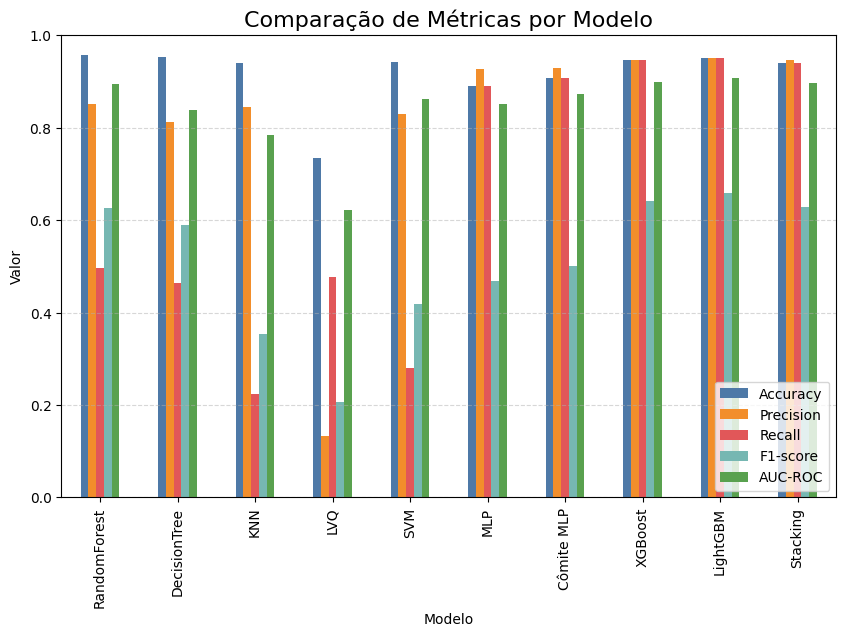

In [ ]:
import matplotlib.pyplot as plt

# Definir cores fixas para consistência
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

# Plotar cada métrica em barras agrupadas
df_results_for_plt.set_index('Modelo').plot(kind='bar', figsize=(10,6), color=colors)
plt.title("Comparação de Métricas por Modelo", fontsize=16)
plt.ylabel("Valor")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

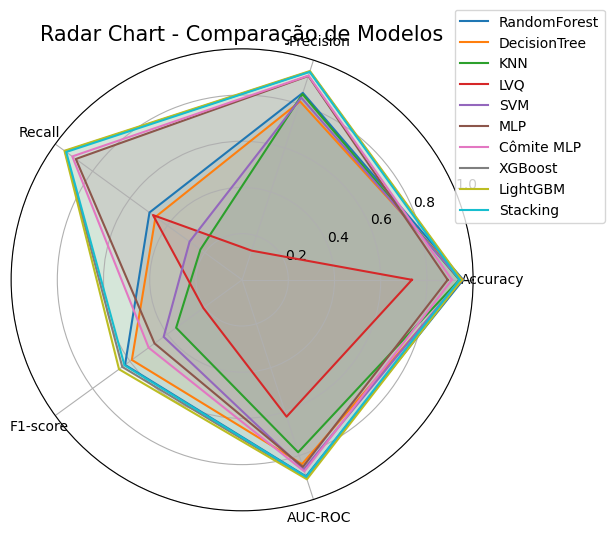

In [ ]:
import numpy as np

# Normalizar dados para plot (já está entre 0 e 1)
metrics = ['Accuracy','Precision','Recall','F1-score','AUC-ROC']
labels = df_results_for_plt['Modelo'].tolist()
values = df_results_for_plt[metrics].values

# Preparar ângulos
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Criar figura
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in enumerate(values):
    stats = row.tolist()
    stats += stats[:1]  # Fechar o gráfico
    ax.plot(angles, stats, label=labels[i])
    ax.fill(angles, stats, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
plt.legend(bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Chart - Comparação de Modelos', fontsize=15)
plt.show()

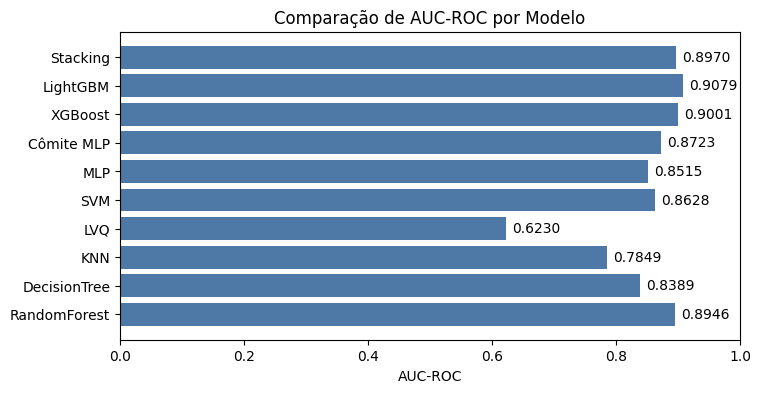

In [ ]:
plt.figure(figsize=(8,4))
plt.barh(df_results_for_plt['Modelo'], df_results_for_plt['AUC-ROC'], color='#4E79A7')
plt.xlabel('AUC-ROC')
plt.title('Comparação de AUC-ROC por Modelo')
plt.xlim(0,1)
for index, value in enumerate(df_results_for_plt['AUC-ROC']):
    plt.text(value+0.01, index, f"{value:.4f}", va='center')
plt.show()

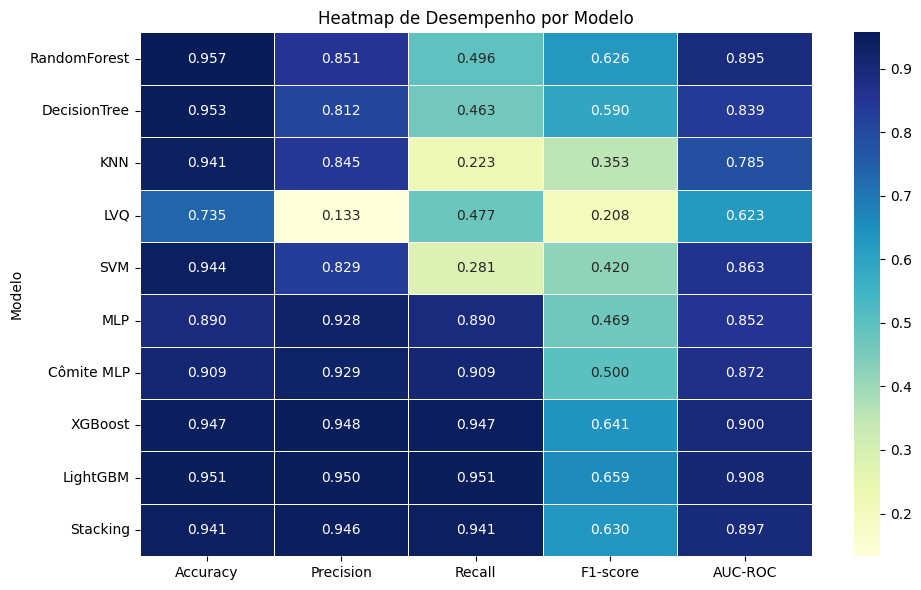

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_results_for_plt.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']],
annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, ax=ax)
plt.title("Heatmap de Desempenho por Modelo")
plt.tight_layout()
plt.show()

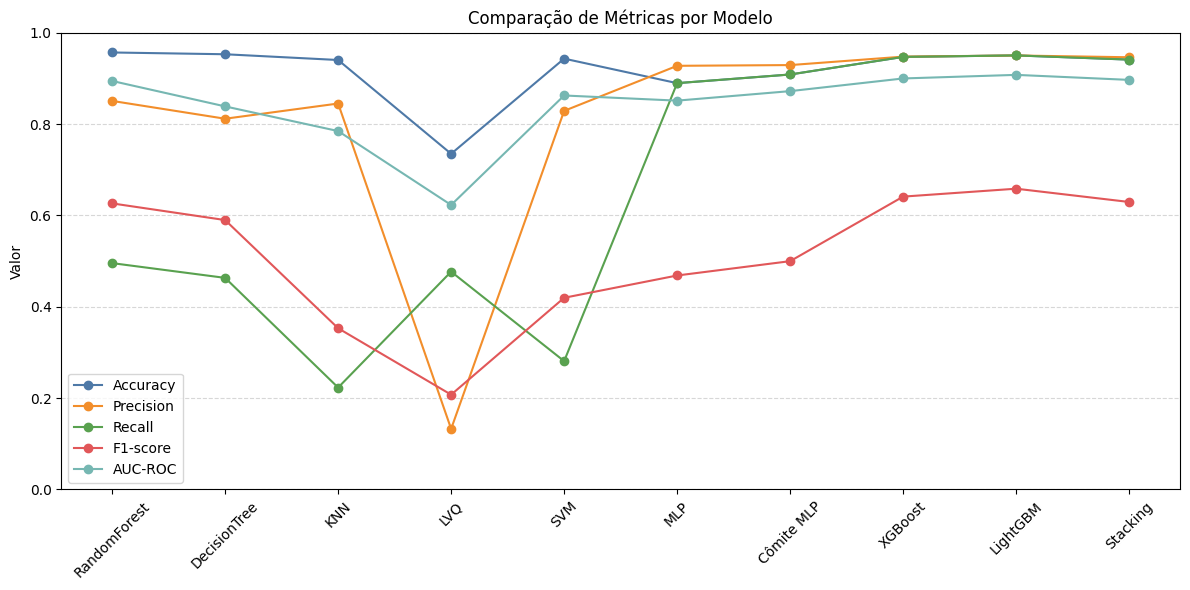

In [ ]:
import matplotlib.pyplot as plt

# Lista de métricas que vamos plotar
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
model_names = df_results_for_plt['Modelo'].tolist()

# Definir cores (uma para cada métrica)
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759', '#76B7B2']

fig, ax = plt.subplots(figsize=(12, 6))

# Plotar cada métrica
for metric, color in zip(metrics, colors):
    ax.plot(model_names, df_results_for_plt[metric], marker='o', label=metric, color=color)

ax.set_title("Comparação de Métricas por Modelo")
ax.set_ylabel("Valor")
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

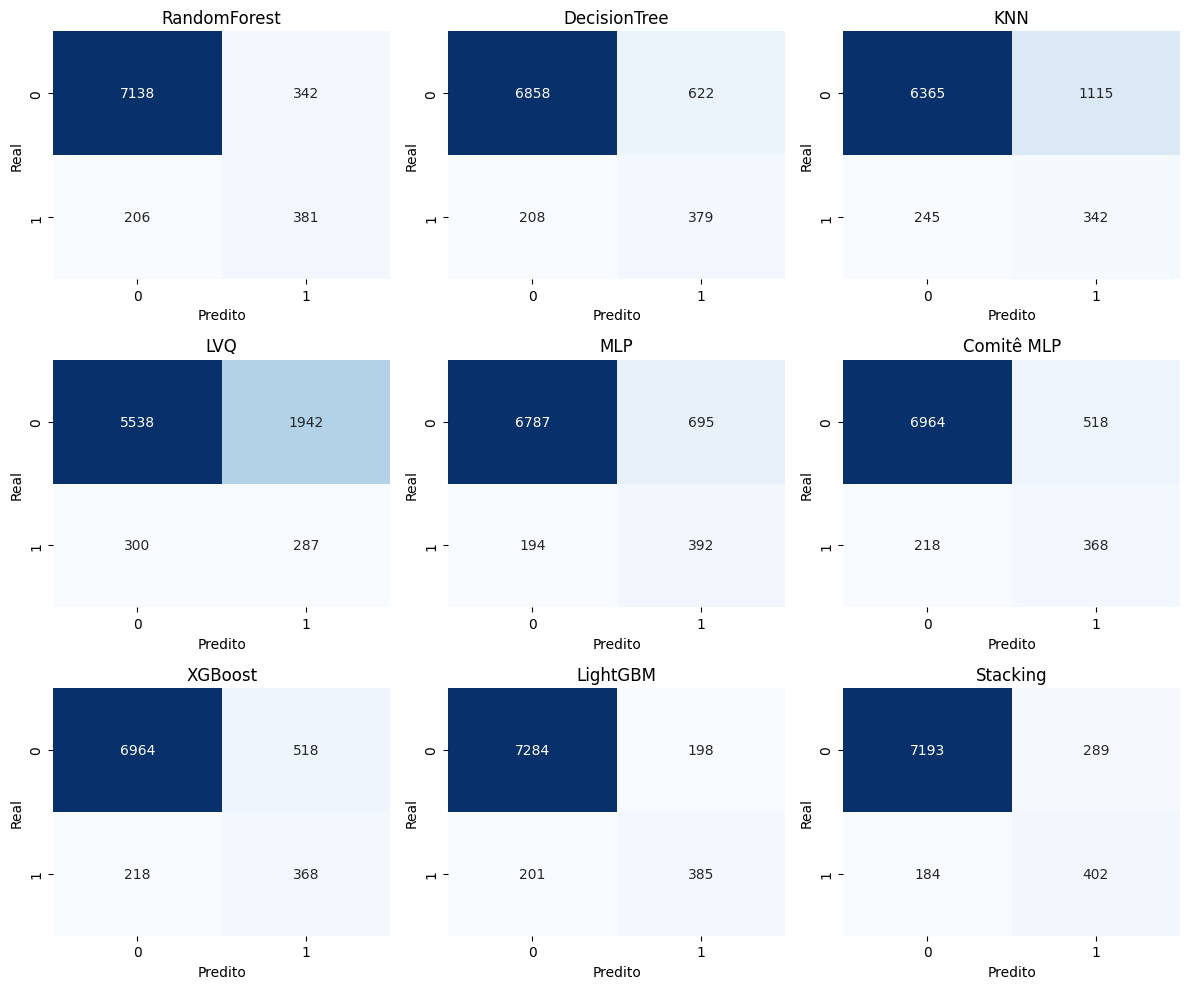

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dicionário com matrizes de confusão
matrizes = {
    'RandomForest': np.array([[7138, 342], [206, 381]]),
    'DecisionTree': np.array([[6858, 622], [208, 379]]),
    'KNN': np.array([[6365, 1115], [245, 342]]),
    'LVQ': np.array([[5538, 1942], [300, 287]]),
    'MLP': np.array([[6787, 695], [194, 392]]),
    'Comitê MLP': np.array([[6964, 518], [218, 368]]),
    'XGBoost': np.array([[6964, 518], [218, 368]]),
    'LightGBM': np.array([[7284, 198], [201, 385]]),
    'Stacking': np.array([[7193, 289], [184, 402]])
}

# Plotando um grid de heatmaps
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for ax, (modelo, matriz) in zip(axes.flatten(), matrizes.items()):
    sns.heatmap(matriz, annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(modelo)
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()


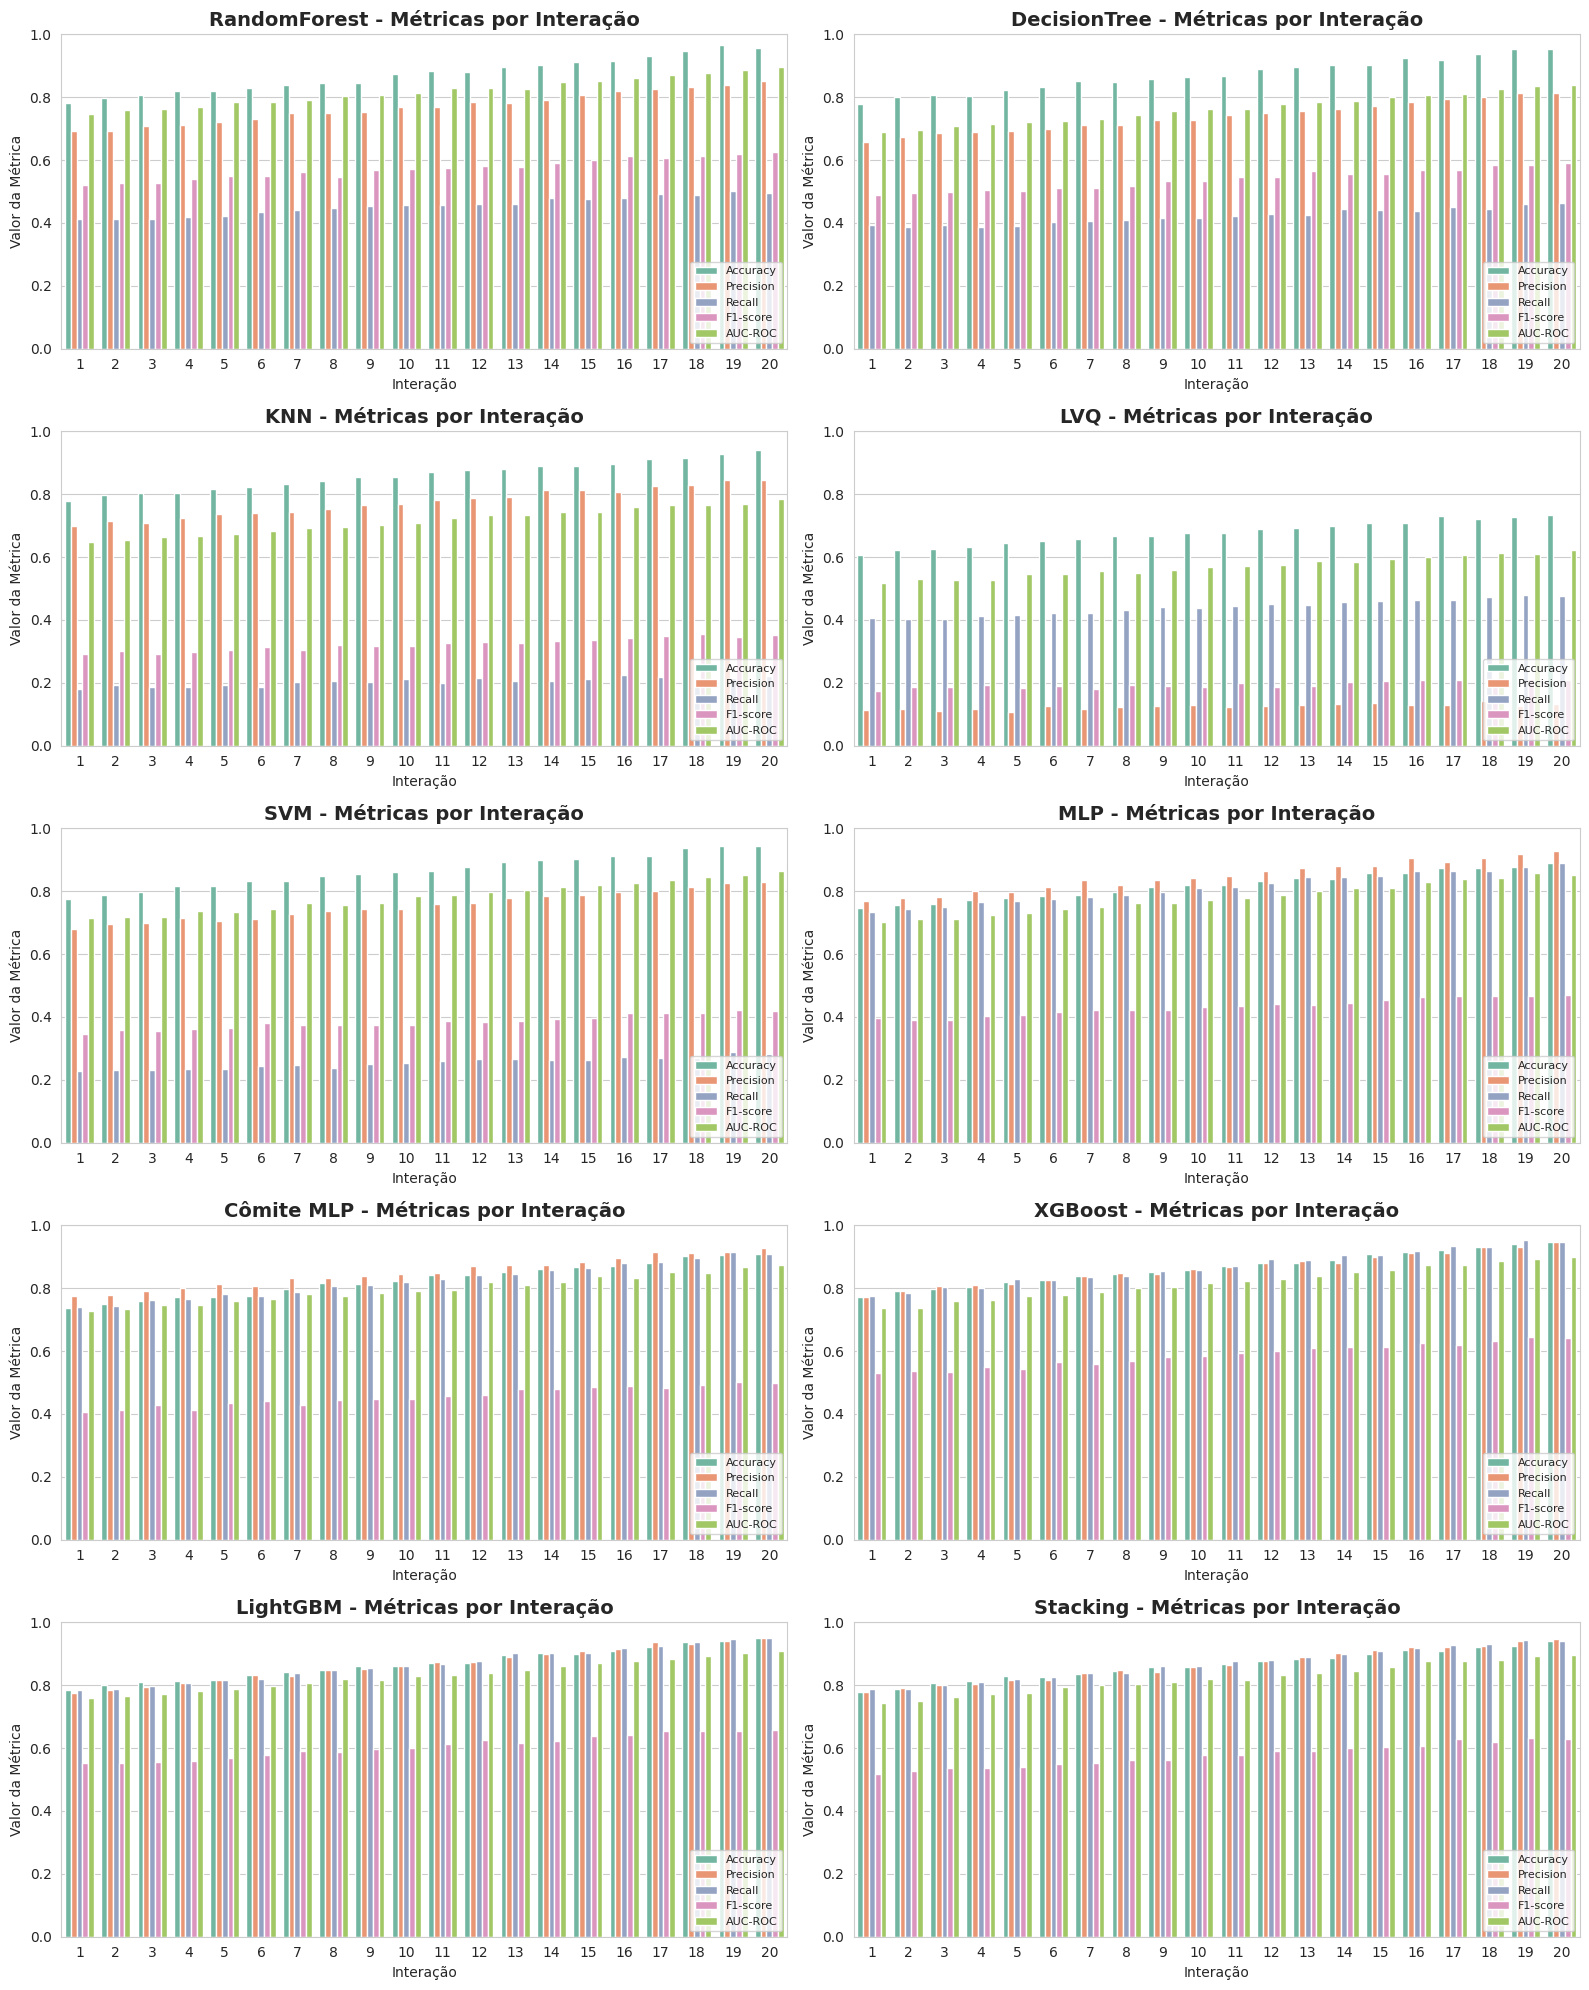

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carregar a planilha ===
file_path = "historico_metricas.xlsx"  # ajuste o caminho no Colab
df = pd.read_excel(file_path)

# === 2. Configurações de exibição ===
sns.set_style("whitegrid")    # <=== corrigido aqui
sns.set_palette("Set2")

# === 3. Descobrir os modelos únicos ===
modelos = df["Modelo"].unique()

# === 4. Criar subplots ===
n_modelos = len(modelos)
n_cols = 2  # número de gráficos por linha
n_rows = (n_modelos + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# === 5. Loop pelos modelos para gerar cada gráfico ===
for idx, modelo in enumerate(modelos):
    ax = axes[idx]

    # Filtrar dados do modelo atual
    dados_modelo = df[df["Modelo"] == modelo]

    # Transformar dados para formato "long" para o seaborn
    df_melt = dados_modelo.melt(
        id_vars=["Modelo", "Interação"],
        value_vars=["Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"],
        var_name="Métrica",
        value_name="Valor"
    )

    # Plotar barras agrupadas por interação
    sns.barplot(
        data=df_melt,
        x="Interação",
        y="Valor",
        hue="Métrica",
        ax=ax
    )

    ax.set_title(f"{modelo} - Métricas por Interação", fontsize=14, fontweight="bold")
    ax.set_ylim(0, 1)  # porque as métricas estão entre 0 e 1
    ax.legend(loc='lower right', fontsize=8)
    ax.set_xlabel("Interação")
    ax.set_ylabel("Valor da Métrica")

# Remover eixos extras caso sobrem
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
